# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

Для расчёта энтропии $H$ используется следующая формула:

$$
H = - \sum_{i=1}^{n} p_i \log p_i
$$

где $p_i$ — доля объектов класса $i$ в узле, а логарифм берётся по **натуральному основанию** (т.е. $\ln$).



In [2]:
p1 = 8/10
p2 = 2/10
H = - (
    0.8 * np.log(0.8) + 0.2 * np.log(0.2)
)
print(f'Энтропия = {H:.2f}')

Энтропия = 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
R_m = np.array([8, 2])  # 8 объектов класса k1, 2 — класса k2
R_left = np.array([8, 0])  # все объекты класса k1
R_right = np.array([0, 2])  # все объекты класса k2

# размеры
total_size = np.sum(R_m)
left_size = np.sum(R_left)
right_size = np.sum(R_right)

def gini(class_cnt) -> int:
    total = np.sum(class_cnt)
    probs = class_cnt / total
    return np.sum(probs * (1 - probs))

# индексы Джини
H_Rm = gini(R_m)
H_Rl = gini(R_left)
H_Rr = gini(R_right)

# Критерий информативности
Q = H_Rm - (left_size / total_size) * H_Rl - (right_size / total_size) * H_Rr

print(f"Индекс Джини в исходной вершине: {H_Rm:.2f}")
print(f"Критерий информативности Q: {Q:.2f}")


Индекс Джини в исходной вершине: 0.32
Критерий информативности Q: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

*В задаче регрессии дерево решений в листовой вершине выдает в качестве предсказания среднее значение целевой переменной для всех объектов в этой вершине.*

In [4]:
y = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
prediction = np.sum(y) / len(y)
print(f"Предсказание: {prediction}")

Предсказание: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

Что реализовано:

- [X] Работает как для классификации (используя индекс Джини), так и для регрессии (используя дисперсию),
- [X] Учитывает вещественные и категориальные признаки,
- [X] Выполнена векторизованно, без циклов (за исключением категорического случая, где это допустимо),
- [X] Удовлетворяет требованию отбора минимального сплита при равных значениях критерия.

In [6]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    feature_vector = np.asarray(feature_vector)
    target_vector = np.asarray(target_vector)

    if feature_type == "real":
        # Сортируем по признаку
        sorted_idx = np.argsort(feature_vector)
        x_sorted = feature_vector[sorted_idx]
        y_sorted = target_vector[sorted_idx]

        # Находим возможные пороги (середины между уникальными значениями)
        unique_x = np.unique(x_sorted)
        thresholds = (unique_x[:-1] + unique_x[1:]) / 2

        if len(thresholds) == 0:
            return np.array([]), np.array([]), None, None

        # Маска для каждой threshold: True, если попадает в левое поддерево
        mask_matrix = x_sorted[:, None] <= thresholds  # shape (n_samples, n_thresholds)

        # Объемы поддеревьев
        left_counts = mask_matrix.sum(axis=0)
        right_counts = len(x_sorted) - left_counts

        # Исключаем пороги с пустыми поддеревьями
        valid = (left_counts > 0) & (right_counts > 0)
        thresholds = thresholds[valid]
        mask_matrix = mask_matrix[:, valid]
        left_counts = left_counts[valid]
        right_counts = right_counts[valid]

        if task == "classification":
            classes = np.unique(target_vector)
            # One-hot метки
            y_onehot = np.array([target_vector == c for c in classes], dtype=int).T  # shape (n_samples, n_classes)

            # Считаем вероятности в левом и правом поддеревьях
            left_sums = mask_matrix.T @ y_onehot  # shape (n_thresholds, n_classes)
            right_sums = y_onehot.sum(axis=0) - left_sums

            left_probs = left_sums / left_counts[:, None]
            right_probs = right_sums / right_counts[:, None]

            # Индекс Джини
            left_gini = np.sum(left_probs * (1 - left_probs), axis=1)
            right_gini = np.sum(right_probs * (1 - right_probs), axis=1)

            gini_total = (
                (left_counts / len(feature_vector)) * left_gini +
                (right_counts / len(feature_vector)) * right_gini
            )

            base_gini = np.sum((np.mean(y_onehot, axis=0)) * (1 - np.mean(y_onehot, axis=0)))
            gains = base_gini - gini_total

        else:  # regression
            # Кумулятивные суммы
            y_cumsum = np.cumsum(y_sorted)
            y_sq_cumsum = np.cumsum(y_sorted ** 2)

            left_sums = mask_matrix.T @ y_sorted
            left_sums_sq = mask_matrix.T @ (y_sorted ** 2)

            right_sums = y_sorted.sum() - left_sums
            right_sums_sq = (y_sorted ** 2).sum() - left_sums_sq

            left_var = (left_sums_sq / left_counts) - (left_sums / left_counts) ** 2
            right_var = (right_sums_sq / right_counts) - (right_sums / right_counts) ** 2

            base_var = np.var(target_vector)
            variance_total = (
                (left_counts / len(feature_vector)) * left_var +
                (right_counts / len(feature_vector)) * right_var
            )

            gains = base_var - variance_total

        best_idx = np.argmax(gains)
        best_threshold = thresholds[best_idx]
        best_gain = gains[best_idx]

        return thresholds, gains, best_threshold, best_gain

    elif feature_type == "categorical":
        values = np.unique(feature_vector)
        thresholds = []
        gains = []

        for val in values:
            mask = feature_vector == val
            left_y = target_vector[mask]
            right_y = target_vector[~mask]

            if len(left_y) == 0 or len(right_y) == 0:
                continue

            if task == "classification":
                def gini(y):
                    _, counts = np.unique(y, return_counts=True)
                    probs = counts / counts.sum()
                    return np.sum(probs * (1 - probs))

                gini_left = gini(left_y)
                gini_right = gini(right_y)

                gini_total = (
                    (len(left_y) / len(feature_vector)) * gini_left +
                    (len(right_y) / len(feature_vector)) * gini_right
                )

                base_gini = gini(target_vector)
                gain = base_gini - gini_total

            else:  # regression
                var_left = np.var(left_y)
                var_right = np.var(right_y)

                base_var = np.var(target_vector)
                var_total = (
                    (len(left_y) / len(feature_vector)) * var_left +
                    (len(right_y) / len(feature_vector)) * var_right
                )
                gain = base_var - var_total

            thresholds.append(val)
            gains.append(gain)

        if not thresholds:
            return np.array([]), np.array([]), None, None

        gains = np.array(gains)
        thresholds = np.array(thresholds)
        best_idx = np.argmax(gains)
        return thresholds, gains, thresholds[best_idx], gains[best_idx]

    else:
        raise ValueError("Invalid feature_type: must be 'real' or 'categorical'")

Эту функцию можно протестировать на датасете `California Housing` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [7]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = pd.DataFrame(data=housing["data"], columns=housing["feature_names"])
y = housing["target"]
print(housing["DESCR"])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [8]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["MedInc"].to_numpy(),
    y,
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

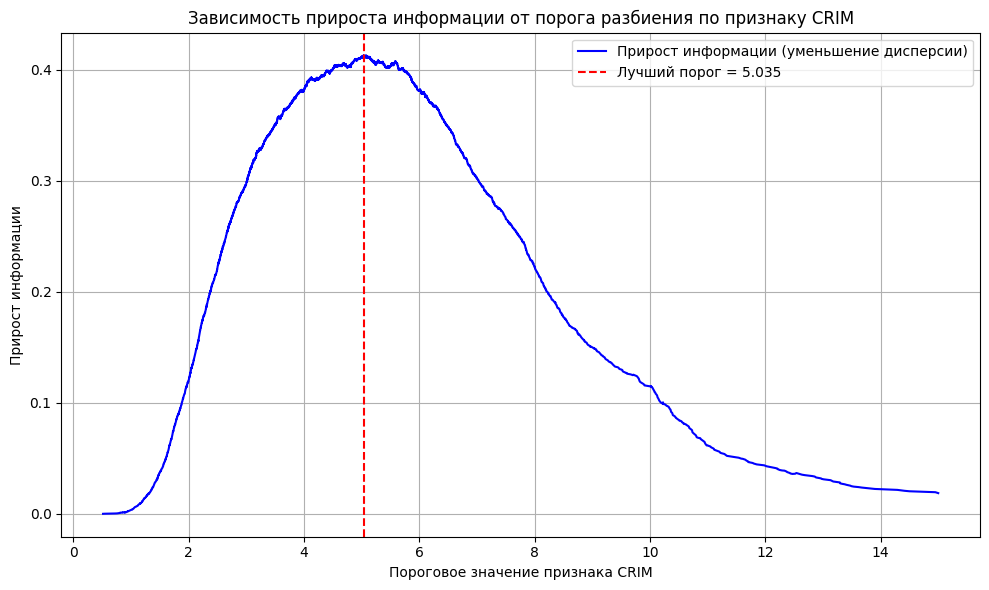

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, variances, label="Прирост информации (уменьшение дисперсии)", color="blue")
plt.axvline(threshold_best, color="red", linestyle="--", label=f"Лучший порог = {threshold_best:.3f}")
plt.xlabel("Пороговое значение признака CRIM")
plt.ylabel("Прирост информации")
plt.title("Зависимость прироста информации от порога разбиения по признаку CRIM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [10]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini is not None and (gini_best is None or gini > gini_best):
                feature_best = feature
                gini_best = gini
                threshold_best = threshold


                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]
        feature_type = self._feature_types[feature]

        if feature_type == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif feature_type == "categorical":
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type")


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
students = pd.read_csv("drive/MyDrive/students.csv")
students.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


In [18]:
X = students[["STG", "SCG", "STR", "LPR", "PEG"]]
y = students["UNS"].to_numpy()

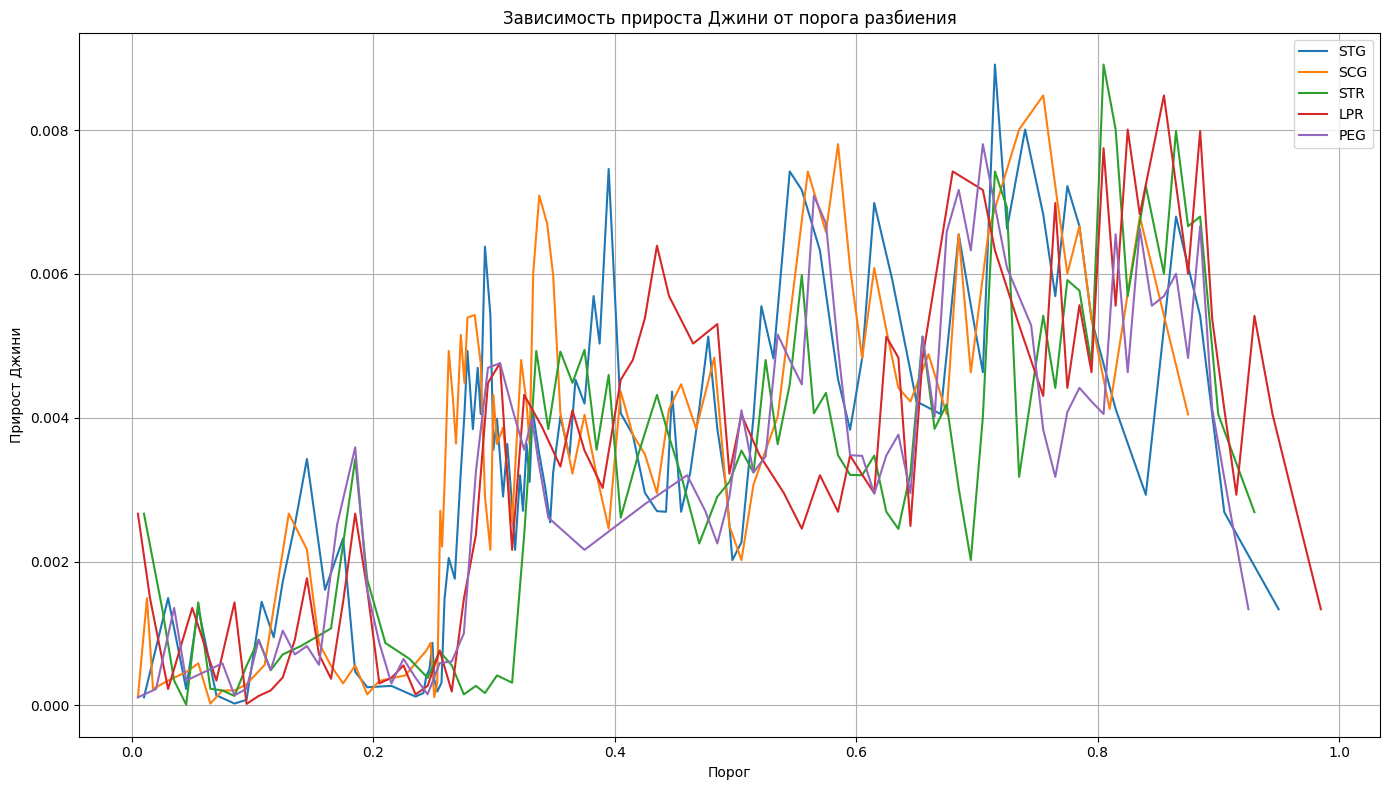

In [19]:
plt.figure(figsize=(14, 8))

for i, column in enumerate(X.columns):
    thresholds, ginis, _, _ = find_best_split(X[column].values, y, task="classification", feature_type="real")
    plt.plot(thresholds, ginis, label=column)

plt.title("Зависимость прироста Джини от порога разбиения")
plt.xlabel("Порог")
plt.ylabel("Прирост Джини")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

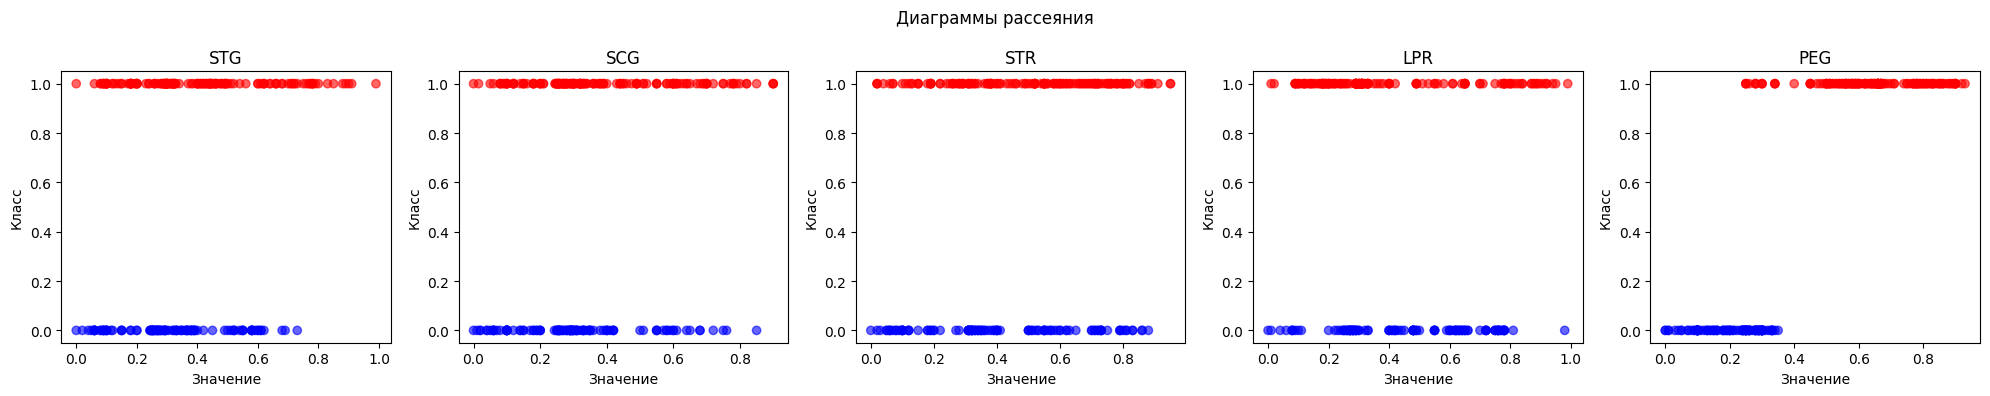

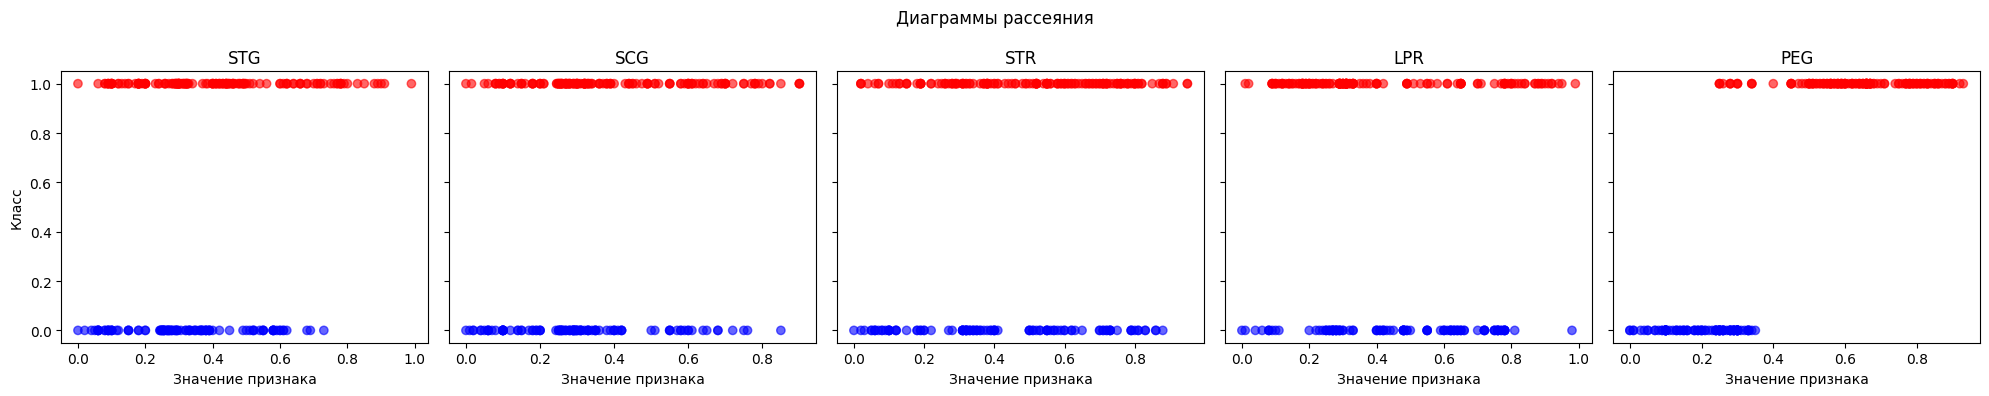

In [20]:
# диаграммы рассеяния "значение признака — класс"
fig, axs = plt.subplots(1, X.shape[1], figsize=(20, 4))
fig.suptitle("Диаграммы рассеяния")

for i, column in enumerate(X.columns):
    axs[i].scatter(X[column], y, alpha=0.6, c=y, cmap='bwr')
    axs[i].set_title(column)
    axs[i].set_xlabel("Значение")
    axs[i].set_ylabel("Класс")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, column in enumerate(X.columns):
    axes[i].scatter(X[column], y, alpha=0.6, c=y, cmap='bwr')
    axes[i].set_title(column)
    axes[i].set_xlabel("Значение признака")
    if i == 0:
        axes[i].set_ylabel("Класс")

plt.suptitle("Диаграммы рассеяния")
plt.tight_layout()
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

- **Вопрос: Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева?**

    Ответ:

    На основании кривых Джини — по тому признаку, для которого минимальное значение критерия Джини (или, точнее, его максимум по убыванию неоднородности) наилучшее — т.е. где график имеет чёткий и выраженный минимум (или максимум прироста информации).

    На моих графиках, наиболее выраженное снижение критерия Джини наблюдается, например, у признаков `STG` и `PEG`.

- **Вопрос: Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния?**

    Ответ:

    Да, согласуется. На диаграммах рассеяния видно:

    1. Что по STG, PEG и отчасти LPR классы (0 и 1) достаточно хорошо отделяются вдоль оси значений признака.
    2. Особенно по STG: значения класса 0 сконцентрированы в одной области, а значения класса 1 — в другой.

- **Вопрос: Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально?**

    Ответ:

    У "хороших" признаков кривая имеет резкое и глубокое "падение" или вогнутую форму с чётким минимумом.

- **Вопрос: Чем отличаются кривые для признаков, по которым деление практически невозможно?**

    Ответ:

    Для "плохих" признаков, по которым сложно разделить выборку, кривая:
    плоская или слабовариативная без выраженных минимумов,
    может быть шумной, что говорит об отсутствии стабильного порога

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Названия признаков (из документации)
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape",
    "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]

df = pd.read_csv(url, header=None, names=columns)

# Обрабатываем пропуски (в 'stalk-root' встречается '?')
df = df.replace("?", np.nan).dropna()

# LabelEncoder для каждого столбца
encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

X = df.drop("class", axis=1).to_numpy()
y = df["class"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, shuffle=True
)

# Типы признаков — все категориальные
feature_types = ["categorical"] * X.shape[1]

# Создаем и обучаем дерево
tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)

# Предсказание
y_pred = tree.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")


Accuracy: 1.0000


<ipython-input-21-ac8e8cafffc9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
<ipython-input-21-ac8e8cafffc9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
<ipython-input-21-ac8e8cafffc9>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [22]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score

In [23]:
data = pd.read_csv('drive/MyDrive/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

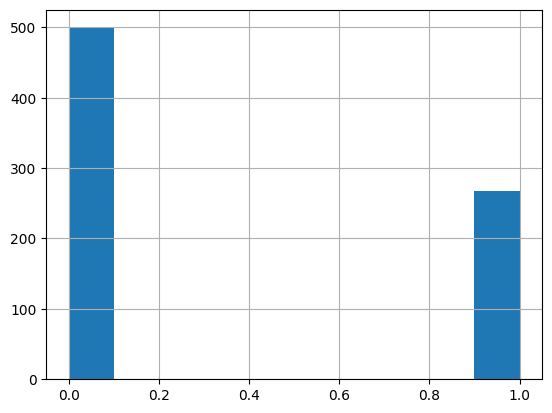

In [24]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [25]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)

print(f"Train shape: {X_train.shape} ({len(X_train) / len(data):.2f} of total)")
print(f"Validation shape: {X_val.shape} ({len(X_val) / len(data):.2f} of total)")
print(f"Test shape: {X_test.shape} ({len(X_test) / len(data):.2f} of total)")

Train shape: (375, 8) (0.49 of total)
Validation shape: (162, 8) (0.21 of total)
Test shape: (231, 8) (0.30 of total)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [26]:
max_depth_list = [3, 5, 7, 9, None]
min_samples_leaf_list = [1, 2, 4, 6, 8]

best_f1 = 0
best_params = {}

In [27]:
for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)

        f1 = f1_score(y_val, y_val_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_params = {"max_depth": max_depth, "min_samples_leaf": min_samples_leaf}

In [28]:
print(f"Лучшие параметры: {best_params}, f1 на валидационной: {best_f1:.4f}")

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 1}, f1 на валидационной: 0.5455


In [29]:
final_clf = DecisionTreeClassifier(**best_params, random_state=42)
final_clf.fit(X_train_full, y_train_full)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [30]:
y_test_pred = final_clf.predict(X_test)
y_test_proba = final_clf.predict_proba(X_test)[:, 1]

In [31]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

In [32]:
print("Test")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Test
accuracy: 0.7662
precision: 0.8000
recall: 0.4444
AUC-ROC: 0.8182


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [33]:
bagging_clf = BaggingClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

bagging_clf.fit(X_train_full, y_train_full)

y_test_pred = bagging_clf.predict(X_test)
y_test_proba = bagging_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_proba)

print("Bagging (50 trees):")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Bagging (50 trees):
accuracy: 0.7532
precision: 0.6875
recall: 0.5432
AUC-ROC: 0.8269


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [34]:
max_depth_list = [3, 5, 7, 10, None]
min_samples_split_list = [2, 5, 10]

best_score = -np.inf
best_params = {}

f1_scorer = make_scorer(f1_score)

for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
        rf = RandomForestClassifier(
            n_estimators=50,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
        scores = cross_val_score(rf, X_train_full, y_train_full, cv=5, scoring=f1_scorer, n_jobs=-1)
        mean_score = scores.mean()

        print(f"max_depth={max_depth}, min_samples_split={min_samples_split}, mean F1={mean_score:.4f}")

        if mean_score > best_score:
            best_score = mean_score
            best_params = {"max_depth": max_depth, "min_samples_split": min_samples_split}

best_params, best_score

max_depth=3, min_samples_split=2, mean F1=0.5872
max_depth=3, min_samples_split=5, mean F1=0.5829
max_depth=3, min_samples_split=10, mean F1=0.5860
max_depth=5, min_samples_split=2, mean F1=0.5922
max_depth=5, min_samples_split=5, mean F1=0.5817
max_depth=5, min_samples_split=10, mean F1=0.5795
max_depth=7, min_samples_split=2, mean F1=0.5765
max_depth=7, min_samples_split=5, mean F1=0.5866
max_depth=7, min_samples_split=10, mean F1=0.5824
max_depth=10, min_samples_split=2, mean F1=0.6049
max_depth=10, min_samples_split=5, mean F1=0.6321
max_depth=10, min_samples_split=10, mean F1=0.6202
max_depth=None, min_samples_split=2, mean F1=0.5841
max_depth=None, min_samples_split=5, mean F1=0.6065
max_depth=None, min_samples_split=10, mean F1=0.6334


({'max_depth': None, 'min_samples_split': 10}, np.float64(0.6334310134310134))

In [35]:
best_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train_full, y_train_full)

RandomForestClassifier(min_samples_split=10, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [36]:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)

In [37]:
print("\nRandom Forest с подобранными параметрами:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


Random Forest с подобранными параметрами:
Accuracy: 0.7403
Precision: 0.6567
Recall: 0.5432
AUC-ROC: 0.8207


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

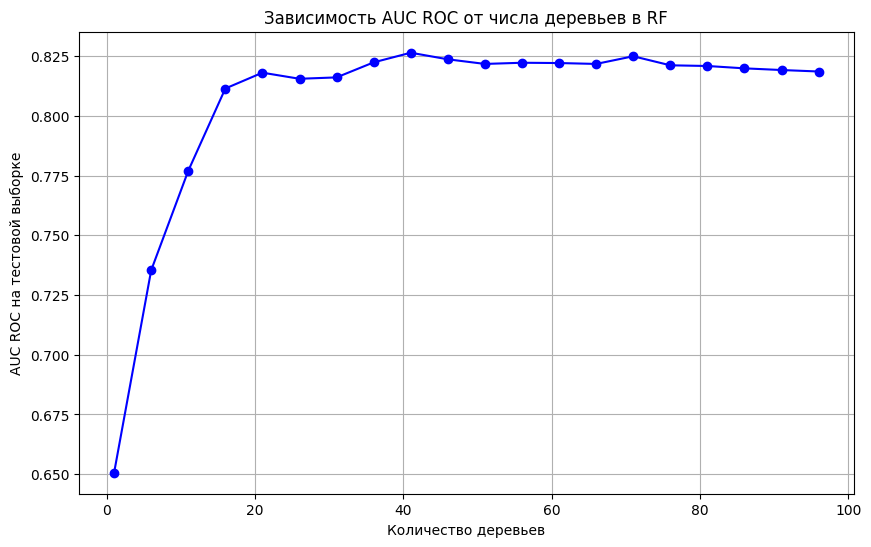

In [38]:
n_estimators_list = list(range(1, 101, 5))
auc_scores = []

for n_trees in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf.fit(X_train_full, y_train_full)

    y_proba = rf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)


plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, auc_scores, marker='o', color='blue')
plt.title('Зависимость AUC ROC от числа деревьев в RF')
plt.xlabel('Количество деревьев')
plt.ylabel('AUC ROC на тестовой выборке')
plt.grid(True)
plt.show()

1. Рост AUC ROC на старте — добавление деревьев сначала существенно улучшает качество модели.

2. Плато после определенного числа деревьев — после ~30–50 деревьев улучшения становятся минимальными.

3. Стабильность — увеличение числа деревьев после плато делает модель устойчивее к случайным флуктуациям, но почти не влияет на AUC ROC.

4. Выбор числа деревьев — разумно выбирать `n_estimators` около значения, где кривая выходит на плато, чтобы сэкономить ресурсы при аналогичном качестве.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

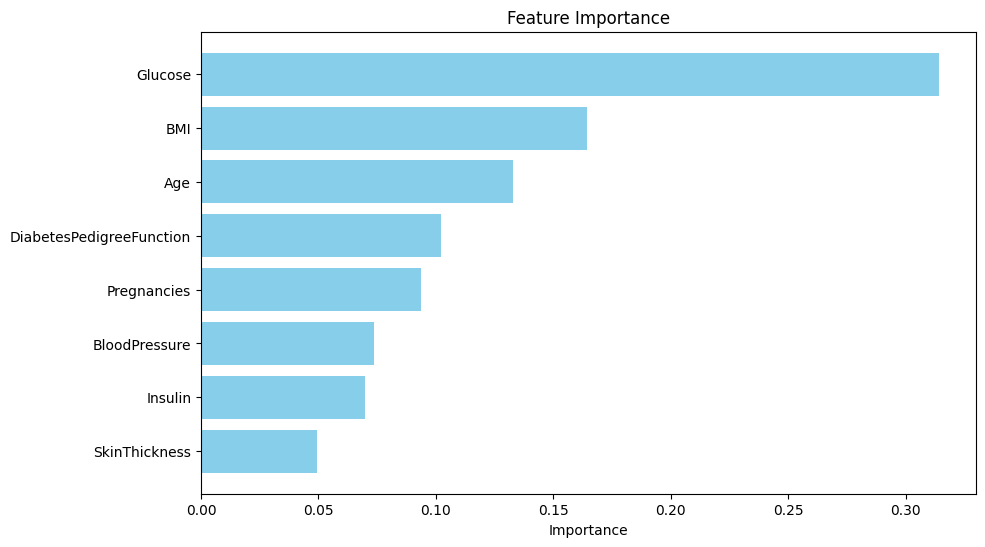

Наиболее важный признак: Glucose


In [39]:
feature_importances = best_rf.feature_importances_
feature_names = X_train_full.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

print("Наиболее важный признак:", importance_df.iloc[0]['feature'])